### Задача:

Построить модель машинного обучения, предсказывающую, является ли вино красным по одиннадцати его характеристикам.

## План решения:

1. Загрузите данные, объедините источники в один датафрейм. Составьте целевую переменную на основе файла, из которого вы получили часть данных (бинарный признак, принимающий значение 1 для данных из файла про красное вино и 0 для данных из файла про белое вино), изучите распределение по ней. Проверьте отсутствие пропусков в данных, отделите фичи и целевой признак друг от друга, разделите данные на обучающую и валидационную части

In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier

In [271]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_red['target'] = 1
df_white['target'] = 0
df = pd.concat([df_red, df_white])
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
3287,6.8,0.21,0.31,2.9,0.046,40.0,121.0,0.99130,3.07,0.65,10.9,7,0
2329,7.6,0.30,0.40,2.2,0.054,29.0,175.0,0.99445,3.19,0.53,9.8,5,0
3630,6.6,0.30,0.25,8.0,0.036,21.0,124.0,0.99362,3.06,0.38,10.8,6,0
4855,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.0,6,0
1424,8.1,0.29,0.49,7.1,0.042,22.0,124.0,0.99440,3.14,0.41,10.8,6,0


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  target                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


Пропуски в значениях отсутствуют.

In [273]:
features = df.drop(['target'], axis=1)
target = df['target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=35)

2. Поскольку выборка несбалансирована, воспользуемся для оценки качества модели новой метрикой balanced_accuracy_score. Изучите формулу расчета метрики в документации и реализуйте функцию balanced_accuracy_score_my для ее расчета. На вход она должна принимать правильные и прогнозные метки классов, а возвращать число от 0 до 1. Убедитесь, что вы корректно реализовали расчет, сравнив значения, получаемые библиотечной реализацией и собственной, подавая на вход векторы:
y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

In [274]:
def balanced_accuracy_score_my(y_true, y_pred):
    
    classes = np.unique(y_true)
    
    tpr = []  # True Positive Rate
    fpr = []  # False Positive Rate
    for cls in classes:
        tp = ((y_true == cls) & (y_pred == cls)).sum()
        fn = ((y_true == cls) & (y_pred != cls)).sum()
        tn = ((y_true != cls) & (y_pred != cls)).sum()
        fp = ((y_true != cls) & (y_pred == cls)).sum()
        
        if tp + fn > 0:
            tpr.append(tp / (tp + fn))
        if tn + fp > 0:
            fpr.append(tn / (tn + fp))
            
    if len(tpr) + len(fpr) > 0:
        bal_accuracy = (sum(tpr) + sum(fpr)) / (len(tpr) + len(fpr))
    else:
        bal_accuracy = 0 
        
    return bal_accuracy


In [275]:
y_true = [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

# Расчёт метрик
my_score = balanced_accuracy_score_my(y_true, y_pred)
sklearn_score = balanced_accuracy_score(y_true, y_pred)

print(f"balanced_accuracy_score_my: {my_score}")
print(f"balanced_accuracy_score: {sklearn_score}")

balanced_accuracy_score_my: 0.6071428571428572
balanced_accuracy_score: 0.6071428571428572


**Вывод:** Значения метрик совпадают. Рассчет собственной метрики реализован корректно.

3. Подберите лучшую модель решающего дерева:

a. Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях

b. Визуализируйте зависимость качества модели от значения гиперпараметров. Опишите зоны недообучения и переобучения, если вы их наблюдаете.

c. Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

Text(0, 0.5, 'BAS')

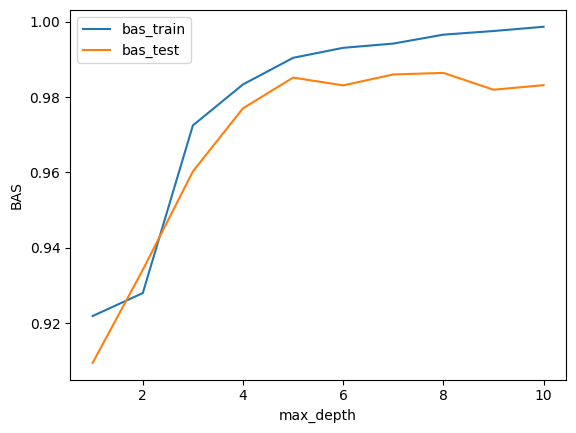

In [276]:
res = []
for param in range(1, 11, 1):
    model = DecisionTreeClassifier(max_depth=param, random_state=42)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([param, balanced_accuracy_score_my(pred_train, target_train), balanced_accuracy_score_my(pred_test, target_test)])
    
res_pd = pd.DataFrame(res, columns=['max_depth', 'bas_train', 'bas_test'])

res_pd.set_index('max_depth')['bas_train'].plot(label='bas_train')
res_pd.set_index('max_depth')['bas_test'].plot(label='bas_test')
plt.legend()
plt.ylabel('BAS')

На графике наглубине дерева меньше 3 наблюдается зона недообучения, а справа от значения лучшего гиперпараметра - зона переобучения.

In [277]:
res_pd[res_pd['bas_test'] == res_pd['bas_test'].max()]

,max_depth,bas_train,bas_test
7,8,0.996558,0.986413


**Вывод:** Наилучшее качество  на валидационной части выборки модель показывает при максимальной глубине дерева, равной 8. Сбалансированная точность тестовой выборки здесь достигается 0.986413.

4. Подберите лучшую модель случайного леса:

a. Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.

b. Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow. Опишите особенности, которые вы наблюдаете.

c. Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.

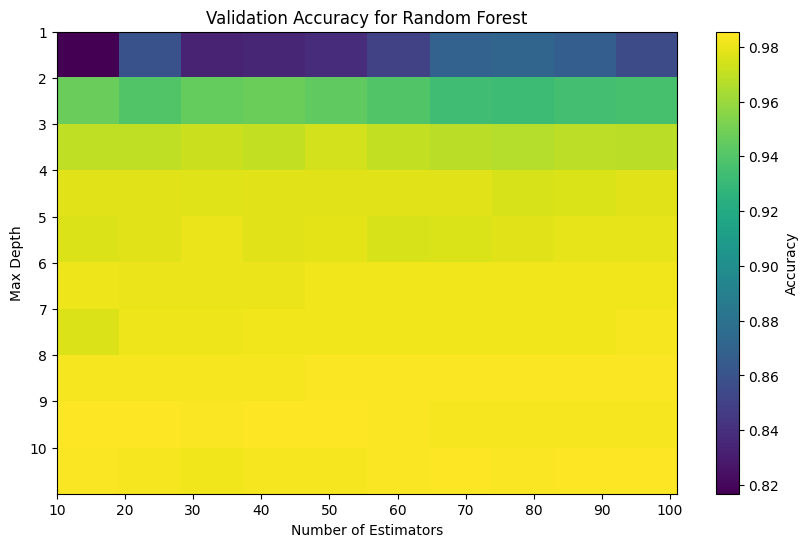

Лучший max_depth: 9, лучшее количество деревьев: 10 с валидационной точностью: 0.9855


In [278]:
max_depths = range(1, 11, 1)
n_estimators = range(10, 101, 10)
bas_matrix = np.zeros((len(max_depths), len(n_estimators)))

for i, md in enumerate(max_depths):
    for j, ne in enumerate(n_estimators):
        model = RandomForestClassifier(max_depth=md, n_estimators=ne, random_state=7)
        model.fit(features_train, target_train)
        
        pred_test = model.predict(features_test)
        bas_matrix[i, j] = balanced_accuracy_score_my(target_test, pred_test)

plt.figure(figsize=(10, 6))
plt.imshow(bas_matrix, aspect='auto', cmap='viridis', 
           extent=[n_estimators.start, n_estimators.stop, max_depths.stop, max_depths.start])
plt.colorbar(label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.xticks(n_estimators)
plt.yticks(max_depths)
plt.title('Validation Accuracy for Random Forest')
plt.show()

# Определение значений гиперпараметров с наилучшей валидационной точностью
best_val_index = np.unravel_index(np.argmax(bas_matrix), bas_matrix.shape)
best_max_depth = max_depths[best_val_index[0]]
best_n_estimators = n_estimators[best_val_index[1]]
best_val_score = bas_matrix[best_val_index]

print(f"Лучший max_depth: {best_max_depth}, лучшее количество деревьев: {best_n_estimators} с валидационной точностью: {best_val_score:.4f}")

### Вывод: 

В данной матрице можно наблюдать следующие особенности:
- Показатели aacuracy в целом высокие, что указывает на хорошую производительность моделей.
- Наблюдается явный тренд роста точности с увеличением количества деревьев. Это может указывать на успешное обучение или оптимизацию модели. 
- Последние уровни глубины деревьев (8-10) показывают высокие показатели точности и стабильности. Это может указывать на то, что модель достигла определенного уровня эффективности, уверенно ведет себя на более сложных задачах, а также остается устойчивой и надежной даже при различных условиях тестирования.

5. Подберите лучший вариант градиентного бустинга:

a. Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.

In [279]:
features_train_xgb, features_val, target_train_xgb, target_val = train_test_split(features_train, target_train, test_size=0.15, random_state=42)

b. Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.

[0]	validation_0-logloss:0.47583	validation_1-logloss:0.45267
[1]	validation_0-logloss:0.41201	validation_1-logloss:0.39448
[2]	validation_0-logloss:0.36085	validation_1-logloss:0.34878
[3]	validation_0-logloss:0.31878	validation_1-logloss:0.31048
[4]	validation_0-logloss:0.28316	validation_1-logloss:0.27780
[5]	validation_0-logloss:0.25281	validation_1-logloss:0.24986
[6]	validation_0-logloss:0.22639	validation_1-logloss:0.22599
[7]	validation_0-logloss:0.20349	validation_1-logloss:0.20485
[8]	validation_0-logloss:0.18326	validation_1-logloss:0.18551
[9]	validation_0-logloss:0.16537	validation_1-logloss:0.16863
Accuracy: 0.9708239873334212


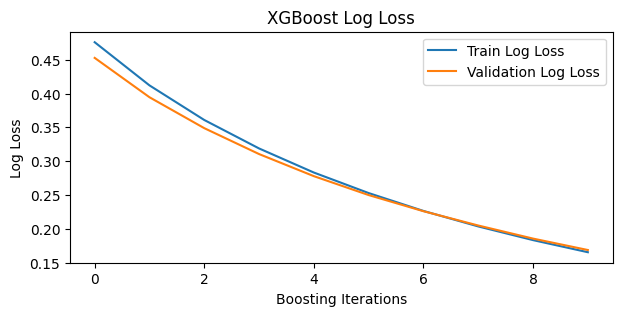

In [280]:
model = XGBClassifier(
    learning_rate=0.1,
    max_depth=9,
    n_estimators=10,
    early_stopping_rounds=5
)

model.fit(features_train_xgb, target_train_xgb,
          eval_set=[(features_train_xgb, target_train_xgb), (features_val, target_val)],
          verbose=True)

y_pred = model.predict(features_val)
accuracy = balanced_accuracy_score_my(target_val, y_pred)

print(f'Accuracy: {accuracy}')

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])

plt.figure(figsize=(7, 3))
plt.plot(range(epochs), results['validation_0']['logloss'], label='Train Log Loss')
plt.plot(range(epochs), results['validation_1']['logloss'], label='Validation Log Loss')
plt.title('XGBoost Log Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


c. На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.

Learning Rate: 0.01, Max Depth: 2, Accuracy: 0.5
Learning Rate: 0.01, Max Depth: 3, Accuracy: 0.5
Learning Rate: 0.01, Max Depth: 5, Accuracy: 0.5
Learning Rate: 0.1, Max Depth: 2, Accuracy: 0.9425221005409685
Learning Rate: 0.1, Max Depth: 3, Accuracy: 0.9722203896732199
Learning Rate: 0.1, Max Depth: 5, Accuracy: 0.9739686414214717
Learning Rate: 0.3, Max Depth: 2, Accuracy: 0.9847990060254211
Learning Rate: 0.3, Max Depth: 3, Accuracy: 0.985673131899547
Learning Rate: 0.3, Max Depth: 5, Accuracy: 0.9802579495975723


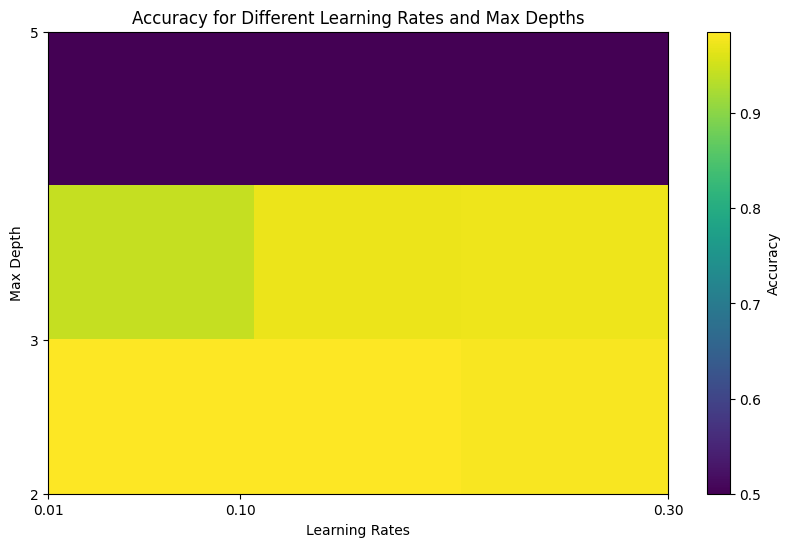

Лучший max_depth: 3, лучший learning_rate: 0.3 с валидационной точностью: 0.9857


In [281]:
learning_rates = [0.01, 0.1, 0.3]
max_depths = [2, 3, 5]
results = np.zeros((len(max_depths), len(learning_rates)))

for i in range(len(learning_rates)):
    for j in range(len(max_depths)):
        model = XGBClassifier(
            learning_rate=learning_rates[i],
            max_depth=max_depths[j],
            n_estimators=10
        )
        
        model.fit(features_train_xgb, target_train_xgb,
                  eval_set=[(features_train_xgb, target_train_xgb), (features_val, target_val)],
                  verbose=False)
        
        y_pred = model.predict(features_val)
        results[i, j] = balanced_accuracy_score_my(target_val, y_pred)
        print(f'Learning Rate: {learning_rates[i]}, Max Depth: {max_depths[j]}, Accuracy: {results[i,j]}')

plt.figure(figsize=(10, 6))
plt.imshow(results, aspect='auto', cmap='viridis', 
           extent=[learning_rates[0], learning_rates[-1], max_depths[0], max_depths[-1]])
plt.colorbar(label='Accuracy')
plt.xlabel('Learning Rates')
plt.ylabel('Max Depth')
plt.xticks(learning_rates)
plt.yticks(max_depths)
plt.title('Accuracy for Different Learning Rates and Max Depths')
plt.show()

best_val_index = np.unravel_index(np.argmax(results), results.shape)
best_max_depth = max_depths[best_val_index[1]]
best_learning_rate = learning_rates[best_val_index[0]]
best_val_score = results[best_val_index]

print(f"Лучший max_depth: {best_max_depth}, лучший learning_rate: {best_learning_rate} с валидационной точностью: {best_val_score:.4f}")


d. Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.

Комбинация learning_rate = 0.3 и max_depth = 3 дала наилучший результат Accuracy = 0.9857. Это означает, что модель хорошо обобщает данные, не переобучая их

e. Увеличьте количество деревьев и опишите эффект. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.

[0]	validation_0-logloss:0.34825	validation_1-logloss:0.33523
[1]	validation_0-logloss:0.24972	validation_1-logloss:0.24231
[2]	validation_0-logloss:0.18759	validation_1-logloss:0.18583
[3]	validation_0-logloss:0.14551	validation_1-logloss:0.14503
[4]	validation_0-logloss:0.11514	validation_1-logloss:0.11651
[5]	validation_0-logloss:0.09307	validation_1-logloss:0.09680
[6]	validation_0-logloss:0.07711	validation_1-logloss:0.07963
[7]	validation_0-logloss:0.06371	validation_1-logloss:0.06820
[8]	validation_0-logloss:0.05421	validation_1-logloss:0.05892
[9]	validation_0-logloss:0.04688	validation_1-logloss:0.05080
[10]	validation_0-logloss:0.03990	validation_1-logloss:0.04668
[11]	validation_0-logloss:0.03449	validation_1-logloss:0.04211
[12]	validation_0-logloss:0.03008	validation_1-logloss:0.03796
[13]	validation_0-logloss:0.02720	validation_1-logloss:0.03518
[14]	validation_0-logloss:0.02460	validation_1-logloss:0.03241
[15]	validation_0-logloss:0.02265	validation_1-logloss:0.03058
[1

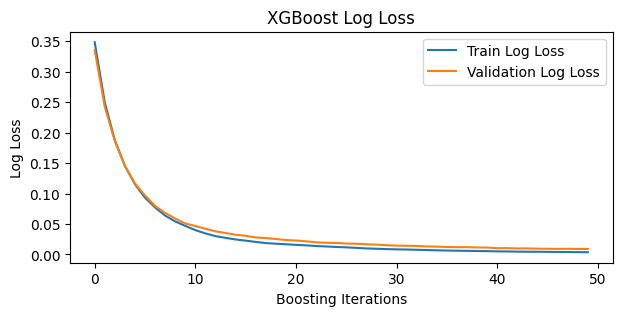

In [282]:
# Увеличение числа деревьев
model = XGBClassifier(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=50,
    eval_metric='logloss',
    early_stopping_rounds=10
)

# Обучение модели с большим количеством деревьев
model.fit(features_train_xgb, target_train_xgb,
          eval_set=[(features_train_xgb, target_train_xgb), (features_val, target_val)],
          verbose=True)

# Проверка точности
y_pred = model.predict(features_val)
pred_train = model.predict(features_train_xgb)
print('Accuracy на тренировочной модели', balanced_accuracy_score_my(target_train_xgb, pred_train))
print('Accuracy на тестовой модели', balanced_accuracy_score_my(target_val, y_pred))

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])

plt.figure(figsize=(7, 3))
plt.plot(range(epochs), results['validation_0']['logloss'], label='Train Log Loss')
plt.plot(range(epochs), results['validation_1']['logloss'], label='Validation Log Loss')
plt.title('XGBoost Log Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

Увеличение числа деревьев может привести к улучшению точности, но если количество деревьев слишком велико, модель может начать переобучаться. Гиперпараметр early_stopping_rounds помогает остановить обучение, если валидационная ошибка не улучшается, тем самым экономя время на обучении.

6. В выводах напишите, какая модель показала себя лучше всего, какого качества удалось достичь.

### Вывод:

Модель градиентного бустинга с большим количеством деревьев показала себя лучше всегою Удалось достичь точности 1 на тренировочной модели и 0.9959812200378237 на валидационной.